In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

# replicate figure 7 from carlesten 

setup: calculate the proportion of transaction fees earned by an adversary playing the pure selfish strategy given block times modelled as an exponential distribution.

In [218]:
np.random.exponential()

0.13796307652619724

In [216]:
state = 0
alpha = 0.3

honestRews = 0
attackRews = 0
remainRews = 0
honestBlcs = 0
attackBlcs = 0

for _ in tqdm(range(int(1e5))):
    blockTime = np.random.exponential(1/100000)
    attBlock  = np.random.binomial(1, alpha)

    if state == 0 and attBlock:
        state       = 1
        remainRews += blockTime  # unclaimed exec rewards on private branch
    elif state == 0 and not attBlock:
        honestRews += blockTime
        honestBlcs += 1

    if state == 1 and attBlock:
        state       = 2
        attackRews += (remainRews + blockTime)  # attacker locks in both blocks worth of exec rewards
        attackBlcs += 2
        remainRews  = 0
    elif state == 1 and not attBlock:
        nextBlockTime = np.random.exponential()
        nextAttBlock  = np.random.binomial(1, alpha)
        # attacker wins all three time period's worth of exec rewards
        if nextAttBlock:
            attackRews += (remainRews + blockTime + nextBlockTime)
            attackBlcs += 2
        #   honest wins all three time period's worth of exec rewards
        else:
            honestRews += (remainRews + blockTime + nextBlockTime)
            honestBlcs += 2
        remainRews = 0

    if state == 2 and attBlock:
        state        = 3
        attackRews  += (remainRews + blockTime)
        remainRews   = 0
        attackBlcs  += 1
    elif state == 2 and not attBlock:
        nextBlockTime = np.random.exponential()
        nextAttBlock  = np.random.binomial(1, alpha)
        # attacker wins all outstanding exec rewards
        if nextAttBlock:
            attackRews += (remainRews + blockTime + nextBlockTime)
            attackBlcs  += 1
        #   honest wins all outstanding exec rewards
        else:
            honestRews  += (remainRews + blockTime + nextBlockTime)
            honestBlcs  += 1
        remainRews = 0

    if state > 2 and attBlock:
        state        += 1
        attackRews   += (remainRews + blockTime)
        remainRews    = 0
        attackBlcs   += 1
    elif state > 2 and not attBlock:
        state      -= 1
        remainRews += blockTime

totalRews = honestRews + attackRews
totalBlcs = honestBlcs + attackBlcs
(honestRews/totalRews, attackRews/totalRews), (honestBlcs/totalBlcs, attackBlcs/totalBlcs), honestBlcs, totalBlcs

100%|██████████| 100000/100000 [00:00<00:00, 125992.68it/s]


((0.6974516120924992, 0.3025483879075008),
 (0.27788669309254305, 0.722113306907457),
 19419,
 69881)

In [264]:
state = [0,0] # (attacker, honest)
alpha = 0.3

honestBlcs = 0
attackBlcs = 0

for _ in tqdm(range(int(1e5))):
    attBlock  = np.random.binomial(1, alpha)

    if state == [0,0]:
        if attBlock:
            state = [1,0]
        else:
            honestBlcs += 1
        continue
    
    if state == [1,0]:
        if attBlock:
            state = [2,0]
        else:
            nextAttBlock  = np.random.binomial(1, alpha)
            if nextAttBlock:
                attackBlcs += 2
            else:
                honestBlcs += 2
            state = [0,0]
        continue
        
    if attBlock:
        state[0] += 1
    else:
        state[1] += 1
    
    diff = state[0] - state[1]
    if diff == 1:
        attackBlcs += state[0]
        state = [0,0]

totalBlcs = honestBlcs + attackBlcs
(honestBlcs/totalBlcs, attackBlcs/totalBlcs), honestBlcs, totalBlcs

100%|██████████| 100000/100000 [00:00<00:00, 258374.64it/s]


((0.7287714014834644, 0.27122859851653564), 65338, 89655)

In [273]:
def simNoGamma(alpha, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    for _ in range(n):
        attBlock  = np.random.binomial(1, alpha)

        if state == [0,0]:
            if attBlock:
                state = [1,0]
            else:
                honestBlcs += 1
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
            else:
                nextAttBlock  = np.random.binomial(1, alpha)
                if nextAttBlock:
                    attackBlcs += 2
                else:
                    honestBlcs += 2
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            state = [0,0]

    totalBlcs = honestBlcs + attackBlcs
    return attackBlcs/totalBlcs

In [254]:
def EyalSirer(a, g):
    num = a * ((1-a)**2) * (4*a + g*(1-2*a)) - a**3
    den = 1 - a * (1 + (2-a) * a)
    return num / den

In [261]:
EyalSirer(0.3, 0)

0.27312614259597795

In [265]:
alphas = np.arange(0.01, 0.5, 0.001)
g0s    = [EyalSirer(a, 0) for a in alphas]

In [294]:
simAlphas = np.arange(0.025, 0.5, 0.025)
simg0s = []
for a in tqdm(simAlphas):
    temp = []
    for j in range(10):
        temp.append(simNoGamma(a))
    simg0s.append(np.mean(temp))

100%|██████████| 19/19 [00:54<00:00,  2.94s/it]

KeyboardInterrupt: 

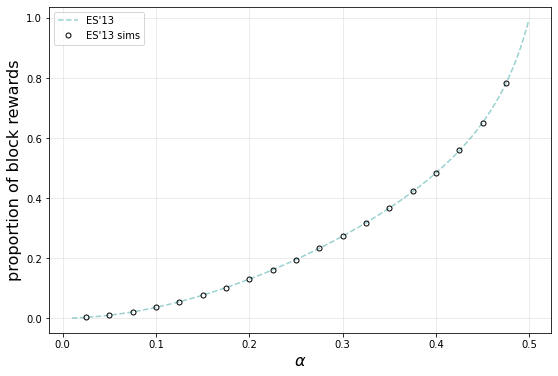

In [296]:
f, ax = plt.subplots(figsize=(9,6))

ax.plot(alphas, g0s, label='ES\'13', linestyle='--', color='darkcyan', alpha=0.4)
ax.plot(simAlphas, simg0s, linestyle='none', color='black', marker='o', fillstyle='none',
        markersize=5, label='ES\'13 sims')

ax.grid(alpha=0.3)
ax.set_xlabel(r'$\alpha$', size=16)
ax.set_ylabel(r'proportion of block rewards', size=16)
ax.legend()
plt.show()